## **Using ARIMA Models for Time Series Forecasting on Wind Speed and Direction**

# **Data Loading and Preprocessing**

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import math
 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [ ]:
data=pd.read_csv('/content/drive/My Drive/Datasets /Wind Turbine Dataset.csv')
df = data.rename(columns={"LV ActivePower (kW)":"Active Power", "Wind Speed (m/s)":"Wind Speed", "Theoretical_Power_Curve (KWh)":"Theoritical Power", "Wind Direction (°)":"Direction"})
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [ ]:
df['Loss']= df['Theoritical Power']-df['Active Power']
df['Loss Percent']= (df['Loss']/df['Theoritical Power']) * 100
df['Date/Time'] = pd.to_datetime(df['Date/Time'],format='%d %m %Y %H:%M')
df['Date'] = df['Date/Time'].dt.date
df['Time'] = df['Date/Time'].dt.time

df['Sin Component'] = df['Wind Speed']*np.sin(math.pi*df['Direction']/180)
df['Cos Component'] = df['Wind Speed']*np.cos(math.pi*df['Direction']/180)
df

,Date/Time,Active Power,Wind Speed,Theoritical Power,Direction,Loss,Loss Percent,Date,Time,Sin Component,Cos Component
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,8.714532,2018-01-01,00:00:00,-5.230563,-0.922769
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,12.722848,2018-01-01,00:10:00,-5.670572,-0.134514
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,21.622774,2018-01-01,00:20:00,-5.210812,0.233413
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,96.481664,18.693375,2018-01-01,00:30:00,-5.658310,0.124264
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,111.052276,22.585236,2018-01-01,00:40:00,-5.562052,-0.420723
...,...,...,...,...,...,...,...,...,...,...,...
50525,2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,433.209835,12.752002,2018-12-31,23:10:00,11.247720,1.881673
50526,2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,-511.297256,-43.586782,2018-12-31,23:20:00,7.293312,0.758502
50527,2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,-412.822178,-23.084812,2018-12-31,23:30:00,8.399870,0.772948
50528,2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,-97.311588,-4.023829,2018-12-31,23:40:00,9.374748,0.936069


# **ARIMA Direct Model**

In [ ]:
# 'dt':df['Date/Time'][:40000],
arima_data = pd.DataFrame({'sc':df['Sin Component'][:40000]}) 
print(arima_data)
print(arima_data.dtypes)

In [ ]:
decomposed_data = seasonal_decompose(arima_data['sc'],freq=1008)   
#frequency is choosen as 1008 as it is the time period of 24*7 hours 

decomposed_data.plot()
plt.show()

trend = decomposed_data.trend
plt.plot(df.index[:40000],df['Sin Component'][:40000],color='orange')
plt.plot(trend)
plt.show()


In [ ]:
test = adfuller(arima_data['sc'])
print(test)

(-11.733479575526479, 1.3245897260348231e-21, 7, 39992, {'1%': -3.43051352569973, '5%': -2.861612274602326, '10%': -2.566808469449866}, 88546.37600036437)


The adfuller test helps us predict the stationarity of data. Our data is stationery according to this test 

In [ ]:
model = ARIMA(arima_data['sc'],order=(5,0,1))
result = model.fit()
result.summary()

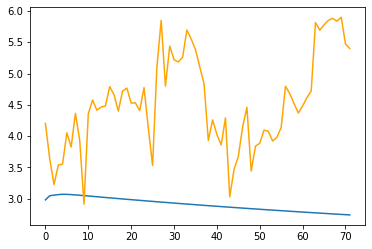

In [ ]:
# prediction = result.predict(40000,50529,df['Sin Component'])
prediction = result.forecast(steps=72)[0]
plt.plot(prediction)

plt.plot(df.index[:72],df['Sin Component'][40000:40072],color='orange')

As we can see in the above implementation that due to the noise the model isn't able to predict anything significant. So we try to smoothen out data by taking window size as 6 in rolling means. 

# **ARIMA on Moving Averages**

             sc
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
...         ...
39995  3.752377
39996  3.860061
39997  3.908497
39998  3.925785
39999  3.831107

[40000 rows x 1 columns]


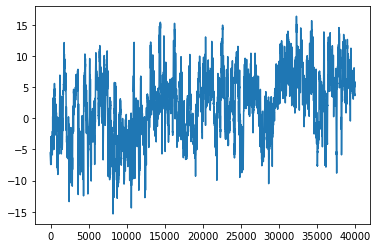

In [ ]:
hourly_arima_data=arima_data.rolling(window=6).mean()
print(hourly_arima_data)
plt.plot(hourly_arima_data)

In [ ]:
clean = hourly_arima_data.dropna()
print(clean)

             sc
5     -5.485215
6     -5.576793
7     -5.496551
8     -5.520436
9     -5.480152
...         ...
39995  3.752377
39996  3.860061
39997  3.908497
39998  3.925785
39999  3.831107

[39995 rows x 1 columns]


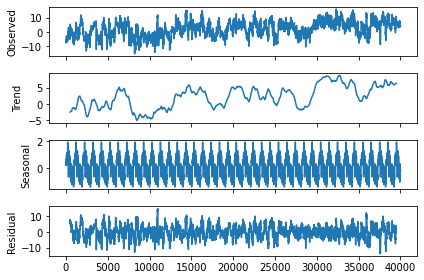

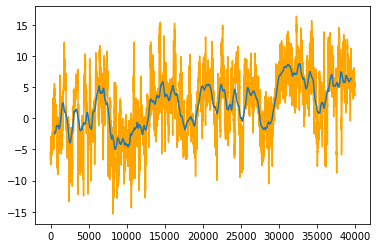

In [ ]:
decomposed_data = seasonal_decompose(clean['sc'],freq=1008)   
#frequency is choosen as 1008 as it is the time period of 24*7 hours 

decomposed_data.plot()
plt.show()

trend = decomposed_data.trend
plt.plot(df.index[:39995],clean['sc'][:40000],color='orange')
plt.plot(trend)
plt.show()

In [ ]:
test = adfuller(clean['sc'])
print(test)

(-9.08808737427931, 3.8907622118140035e-15, 54, 39940, {'1%': -3.4305137386161793, '5%': -2.861612368703909, '10%': -2.566808519537569}, -51147.086293315006)


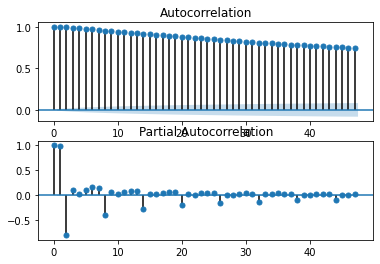

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(clean['sc'], ax=plt.gca())
plt.subplot(212)
plot_pacf(clean['sc'], ax=plt.gca())
plt.show()

In [ ]:
model = ARIMA(clean['sc'],order=(5,0,2))
result = model.fit()
result

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



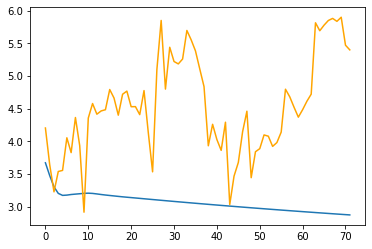

In [ ]:
# prediction = result.predict(40000,40438)
# prediction = pd.DataFrame({'dt':1,'sc':2})
# print(prediction)
prediction = result.forecast(steps=72)[0]
plt.plot(prediction)
plt.plot(df.index[:72],df['Sin Component'][40000:40072],color='orange')

As we can see even moving averages is not providing much good results. So we try by taking mean of the data. By mean we mean taking mean of the 1 hour period. 

# **ARIMA on Average and Daily Moving Average**

In [ ]:
avg_data = []
for i in range(6667):
  avg_data.append(arima_data['sc'][i*6:i*6+6].mean())
plt.plot(avg_data)

In [ ]:
final = pd.DataFrame(avg_data,columns=['sc_avg'])
ma_avg_data=final.rolling(window=24).mean()

clean = ma_avg_data.dropna()
print(clean)

plt.plot(clean)

In [ ]:
test = adfuller(clean['sc_avg'])
print(test)

In [ ]:
plt.figure()
plt.subplot(211)
plot_acf(clean['sc_avg'], ax=plt.gca())
plt.subplot(212)
plot_pacf(clean['sc_avg'], ax=plt.gca())
plt.show()

In [ ]:
model = ARIMA(clean['sc_avg'],order=(1,0,11))
result = model.fit()
result

In [ ]:
prediction = result.forecast(steps=72)[2]
plt.plot(prediction)

# plt.plot(df.index[:72],clean['sc_avg'][],color='orange')

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = pd.DataFrame({'cc' : df['Cos Component'][:50000]})
data

,cc
0,-0.922769
1,-0.134514
2,0.233413
3,0.124264
4,-0.420723
...,...
49995,-0.049991
49996,-0.283428
49997,-0.316795
49998,-0.521740


In [ ]:
model = ExponentialSmoothing(data, seasonal='additive',seasonal_periods=432)
model_fit = model.fit()

yhat = model_fit.forecast(steps=432)
yhat

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


50000   -0.848193
50001   -1.248795
50002   -1.366698
50003   -1.373055
50004   -0.935991
           ...   
50427   -0.705265
50428   -1.007485
50429   -0.667111
50430   -0.761706
50431   -0.590939
Length: 432, dtype: float64

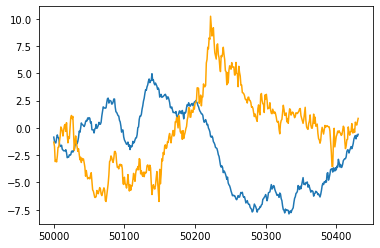

In [ ]:
plt.plot(yhat)
plt.plot(df.index[50000:50432],df['Cos Component'][50000:50432],color='orange')

In [ ]:
!pip install gluonts
!pip install mxnet

In [ ]:
import mxnet as mx
from mxnet import gluon
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.dataset.common import ListDataset

In [ ]:
data = pd.DataFrame({'value':df['Sin Component'][:40000]}) 
data.index = df['Date/Time'][:40000]

train_data = ListDataset([{'start':data.index[0], "target":data.value[:40000]}],freq = "10min")
test_data = ListDataset([{'start':data.index[0], "target":data.value[:40432]}],freq = "10min")

In [ ]:
estimator = DeepAREstimator(freq = '10min', prediction_length=432, trainer=Trainer(epochs=15))
predictor = estimator.train(training_data=train_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [01:16<00:00,  1.52s/it, epoch=15/15, avg_epoch_loss=0.955]


In [ ]:
x = predictor.predict(test_data)
type(x)

generator

In [ ]:
a = next(x)

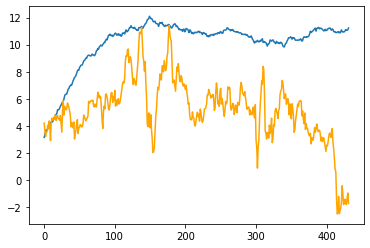

In [ ]:
forecast = a.mean

plt.plot(forecast)
plt.plot(df.index[:432],df['Sin Component'][40000:40432],color='orange')